# Udacity Self-Driving Car Engineer Nanodegree Program

## Vehicle Detection
-------------------------

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

But before all that, let's initialise and explore what we're working with!

In [23]:
# imports
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [ ]:
# globals

# images
vehicle_paths = glob.glob('./vehicles/*/*.png')
non_vehicle_paths = glob.glob('./non-vehicles/*/*.png')

print(len(vehicle_paths), len(non_vehicle_paths))

In [ ]:
def explore(vehicle_data, non_vehicle_data):
    data_dict = {}
    data_dict["num_cars"] = len(vehicle_data)
    data_dict["num_notcars"] = len(non_vehicle_data)
    image = vehicle_data[0]
    data_dict["image_shape"] = image.shape
    data_dict["data_type"] = image.dtype

    print("Number of car images (augmented): ", data_dict["num_cars"])
    print("Number of non-car images (augmented): ", data_dict["num_notcars"])
    print("Image dimensions: ", data_dict["image_shape"])
    print("Data type of images: ", data_dict["data_type"], "\n")
    
def plot(vehicle_data, non_vehicle_data):
    rows, cols = 4, 4
    num_images = rows * cols
    limit = num_images // 2
    fig, axs = plt.subplots(rows, cols, figsize=(32, 32))
    fig.subplots_adjust(hspace=.2, wspace=.001)
    axs = axs.ravel()
    
    for i in trange(limit):
        img = vehicle_data[np.random.randint(0, len(vehicle_data))]
        axs[i].set_title('car', fontsize=30)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].imshow(img)
        
        img = non_vehicle_data[np.random.randint(0, len(non_vehicle_data))]
        axs[i + 8].set_title('not car', fontsize=30)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i + 8].axis('off')
        axs[i + 8].imshow(img)
    
def augment(data):
    output = []
    for path in tqdm(data):
        try:
            image = cv2.imread(path)
            to_flip = image.copy()
            flipped = cv2.flip(to_flip, 1)
            output.append(image)
            output.append(flipped)
        except TypeError:
            print(path)
            return
    return output

vehicle_images = augment(vehicle_paths)
non_vehicle_images = augment(non_vehicle_paths)

explore(vehicle_images, non_vehicle_images)
plot(vehicle_images, non_vehicle_images)

Looking good! Worth noting that some of the non-car images do have a bit of car in them, or one in the distance, but not enough to classify. Seems that we don't want an excessively sensitive classifier, or else we'll have too much noise to deal with later on.

So what features are we wanting? Well HOG gradient features are first and foremost - it would seem plausible that colour shouldn't matter much. Colour *can* help distinguish cars a bit more easily though, so we'll add them in. One nice property about the binning we can choose is that the colour features will be a smaller proportion of the total feature vector than the HOG features. This means that less importance is granted to them.

Regarding the size of the feature vectors, well we want a rapid computation, so the smaller the better. Following some experimentation in class, I noticed that compressing the 64x64 images to as low as 16x16 still gave good accuracy, and the LUV colour space seemed to have a fairly specific shape whenever there was a car image, so let's give that a try!

In [2]:
# This code is mainly borrowed from Udacity's course material, with below parameters having been tweaked by
# yours truly.

# parameters
colorspace = 'LUV'
orient = 8
pix_per_cell = 9
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 16
histbins = 32

# function to compute binned color features  
def bin_spatial(img):
    features = cv2.resize(img, (spatial, spatial)).ravel() 
    return features

# function to compute color histogram features  
def color_hist(img, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=histbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=histbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=histbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# function to return HOG features and optionally a visualization
def get_hog_features(img, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, block_norm='L1', feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, block_norm='L1', feature_vector=feature_vec)
        return features

def get_features_from(images):
    features = []
    
    for image in tqdm(images):
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        
        # All 3 HOG channels seemed to make a big difference in accuracy over alternatives - too big to ignore
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:, :, channel]))
        hog_features = np.ravel(hog_features)
        
        # But let's add some colour to our palette! (Please excuse the dreadful pun)
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
        
    return features

In [ ]:
vehicle_features = get_features_from(vehicle_images)
non_vehicle_features = get_features_from(non_vehicle_images)

In [ ]:
print(np.shape(vehicle_features), np.shape(non_vehicle_features))

In [ ]:
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print("X retrieved, normalising ...")
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print("X retrieved and normalised.")

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
print("y retrieved.")

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print("training and test sets partitioned ...")

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
#pickle.dump(vehicle_features, open("vehicle_features.p", "wb"))
#pickle.dump(non_vehicle_features, open("non_vehicle_features.p", "wb"))
pickle.dump(svc, open("model.p","wb"))
pickle.dump(X_scaler, open("X_scaler.p", "wb"))

In [ ]:
vehicle_features = pickle.load(open("vehicle_features.p", "rb"))
non_vehicle_features = pickle.load(open("non_vehicle_features.p", "rb"))

In [4]:
svc = pickle.load(open("model.p", "rb"))
X_scaler = pickle.load(open("X_scaler.p", "rb"))

In [ ]:
t=time.time()
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to test SVC on', X_test.shape[0], 'labels...')

99.34% accuracy is pretty damn good! Very expensive to train, but a damn good result. Since our colour features are fairly compressed (reducing data by 16x before taking histogram data), there is hopefully minimal damage to performance on top of HOG features, and what's left should be fairly low-redundancy. Onward to the sliding windows section!

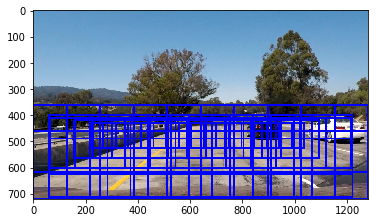

In [5]:
# again, some useful functions from the lectures. One key observation from Drew was that we can narrow the search
# the further away a car is, reducing computational requirements and improving performance. So we'll do that.

# let's get an image to use
image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

# function for drawing boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5), window_list=None):
    # If x and/or y start/stop positions not defined, set to image size
    """if(x_start_stop == (None, None) or y_start_stop == (None, None)):
        x_start_stop, y_start_stop = (0, img.shape[1]), (0, img.shape[0])"""
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    if window_list is None:
        window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[image.shape[0] // 2, None], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.6))
windows = slide_window(image, x_start_stop=[60, None], y_start_stop=[image.shape[0] // 2 + 40, None], 
                    xy_window=(224, 224), xy_overlap=(0.3, 0.6), window_list=windows)
windows = slide_window(image, x_start_stop=[64, None], y_start_stop=[image.shape[0] // 2 + 50, None], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.1), window_list=windows)
windows = slide_window(image, x_start_stop=[156, 1124], y_start_stop=[image.shape[0] // 2 + 60, 630], 
                    xy_window=(144, 144), xy_overlap=(0.5, 0.1), window_list=windows)
windows = slide_window(image, x_start_stop=[220, 1060], y_start_stop=[image.shape[0] // 2 + 70, 600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.1), window_list=windows) 


window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
                   
plt.imshow(window_img)      

Well that's a start, but it seems that constraining the x-region would possibly miss those cars - recall that lane curvature and the ground truth of roads not always being perfectly flat means this constraint needs to be done smarter.

One observation is that we don't need to search the whole image, and maybe we don't need to search every frame. Instead, we can search for the cars we detected before, and only search for where new cars might show up (i.e. the sides and in the distance ahead). That way we reduce the computational load, and can increase accuracy in those areas.

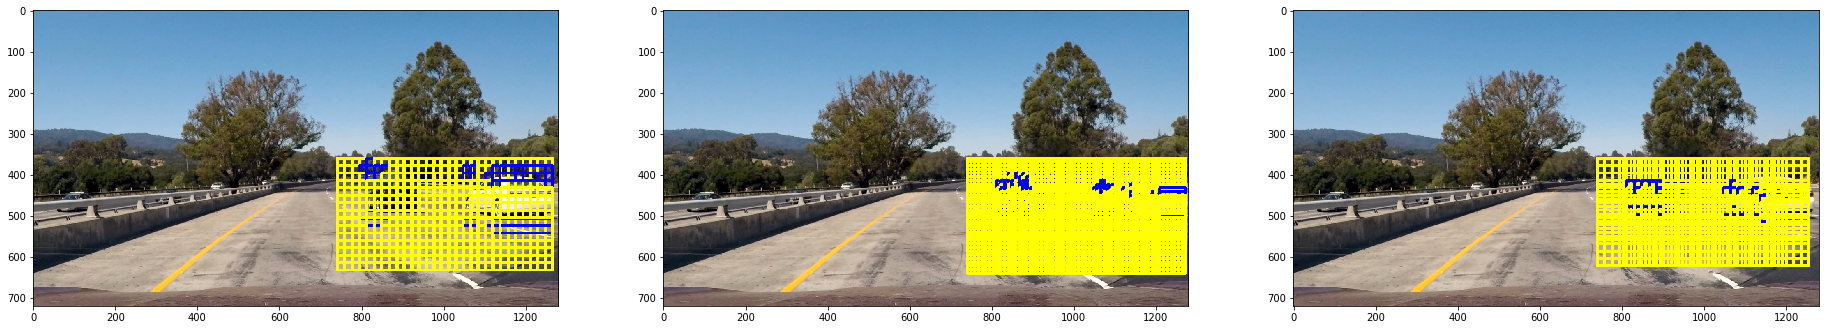

In [68]:
def display_cars(img, ystart, ystop, xstart, xstop, scale, step):
    draw_img = np.copy(img)
    
    restricted_img = img[ystart:ystop,xstart:xstop,:]

    luv = cv2.cvtColor(restricted_img, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = luv.shape
        luv = cv2.resize(luv, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = luv[:,:,0]
    ch2 = luv[:,:,1]
    ch3 = luv[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
        
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // step
    nysteps = (nyblocks - nblocks_per_window) // step
    
    if nxsteps == 0 or nysteps == 0:
        print("error, cannot retrieve windows")
        return img
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*step
            xpos = xb*step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = []
            hog_features.append(hog_feat1)
            hog_features.append(hog_feat2)
            hog_features.append(hog_feat3)
            hog_features = np.ravel(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(luv[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            
            x = np.concatenate((hog_features, spatial_features, hist_features))
            test_features = X_scaler.transform(x.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)+ystart
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw),(0,0,255),6)    
            else:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)+ystart
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw),(255,255,0),6)
                
    return draw_img

def find_cars(img, ystart, ystop, xstart, xstop, scale, step, boxes=None):
    if boxes is None:
        boxes = []
    restricted_img = img[ystart:ystop,xstart:xstop,:]

    luv = cv2.cvtColor(restricted_img, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = luv.shape
        luv = cv2.resize(luv, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = luv[:,:,0]
    ch2 = luv[:,:,1]
    ch3 = luv[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
        
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // step
    nysteps = (nyblocks - nblocks_per_window) // step
    
    if nxsteps == 0 or nysteps == 0:
        print("error, cannot retrieve windows")
        return img
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*step
            xpos = xb*step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = []
            hog_features.append(hog_feat1)
            hog_features.append(hog_feat2)
            hog_features.append(hog_feat3)
            hog_features = np.ravel(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(luv[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            x = np.concatenate((hog_features, spatial_features, hist_features))
            test_features = X_scaler.transform(x.reshape(1, -1))    
            test_predicted = svc.predict(test_features)
            
            if test_predicted:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)+ystart
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw)),(int(xbox_left+win_draw),int(ytop_draw+win_draw))))
    return boxes

# ystart = 360
# ystop = 650
# xstart = 0
# xstop = 350
step = 1
scale = 2
    
#out_img1 = display_cars(image, 360, 650, 0, 350, 4, step)
out_img1 = display_cars(image, 360, 650, 740, 1280, 2, step)
out_img2 = display_cars(image, 360, 650, 740, 1280, 1, step)
out_img3 = display_cars(image, 360, 650, 740, 1280, 1, 2)
#out_img3 = display_cars(image, 400, 500, 440, 840, 1, 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(32, 32))

ax1.imshow(out_img1)
ax2.imshow(out_img2)
ax3.imshow(out_img3)

Very frustrating... My model trained with the assumption of 9 cells per pixel, but I suspect that is throwing off drawing boxes because for certain scales and sizes no windows are retrieved. However the model is picking up the cars nice and clear.

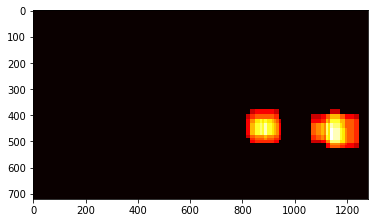

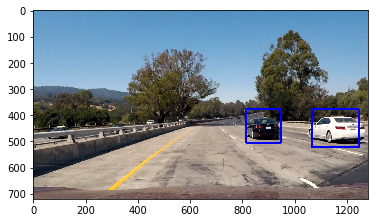

True

In [73]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def get_labeled_bboxes(labels):
    boxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    return boxes

boxes = find_cars(image, 360, 650, 740, 1280, 2, step)
boxes = find_cars(image, 360, 650, 740, 1280, 1, 2, boxes)
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,boxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.imshow(heatmap, cmap='hot')
plt.show()
plt.imshow(draw_img)
plt.show()

cv2.imwrite("./examples/final_result.png", draw_img)
cv2.imwrite("./examples/heatmap.png", heatmap)

In [76]:
previous_heat = np.zeros((720, 1280))
previous_frame_boxes = []

def video_pipeline(image):
    global previous_heat, previous_frame_boxes
    if video_pipeline.is_even:
        boxes = find_cars(image, 360, 650, 740, 1280, 2, step)
        #boxes = find_cars(image, 360, 650, 740, 1280, 1, step, boxes)
        boxes = find_cars(image, 360, 650, 740, 1280, 1, 2, boxes)
        
        boxes = find_cars(image, 360, 650, 0, 540, 2, step, boxes)
        #boxes = find_cars(image, 360, 650, 0, 540, 1, step, boxes)
        boxes = find_cars(image, 360, 650, 0, 540, 1, 2, boxes)
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, boxes)
        current_heat = previous_heat + heat
        previous_heat = heat
        thresholded_heat = apply_threshold(current_heat, 3)
        heatmap = np.clip(current_heat, 0, 255)
        labels = label(heatmap)
        boxes = get_labeled_bboxes(labels)
        previous_frame_boxes = boxes
    else:
        boxes = previous_frame_boxes
    output = draw_boxes(np.copy(image), boxes, color=(0, 0, 255), thick=6)
    video_pipeline.is_even = not video_pipeline.is_even
    return output
    
video_pipeline.is_even = True

In [77]:
## Video processing, etc.
output = './output_video.mp4'

clip1 = VideoFileClip("./project_video.mp4")
video_clip = clip1.fl_image(video_pipeline).subclip(0, 40) #NOTE: this function expects color images!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████▉| 1000/1001 [11:57<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

CPU times: user 11min 31s, sys: 17.9 s, total: 11min 49s
Wall time: 11min 59s
